# The Volterra-Lotka system

In [1]:
import numpy as np
import numpy.polynomial.polynomial as poly
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy.optimize import least_squares
from scipy import special
from scipy.integrate import solve_ivp

In [2]:
# Define the function to deliver the r.h.s. of the system
#def f(t,y):
#    return y[1],-y[0]
# This is the place to insert other DE-Systems. Maybe try van der Pol.
def f(t,r):
    mu=0.1 #mu=0.1  Stellschraube für Rückkopplung
    x,y=r
    dxdt=x-x*y
    dydt=-y+x*y
    return dxdt,dydt
# van der Pol system
#axdot=np.array([0.,1.,0.,0.,0.,0.,0.,0.,0.,0.])
#avdot=np.array([0.,.1,0.,0.,-1.,0.,0.,0.,-.1,0.])

In [3]:
# Integrate dy/dt=f(t,y)
r0=[0.4443542615286089,2.0017635461305257]
t0=0.
t1=10.
dt=0.001
rtol=1.e-10
atol=1.e-12
teval=np.linspace(t0,t1,int((t1-t0)/dt+1))
sol=solve_ivp(f, [t0, t1], r0,method='RK45',t_eval=teval,rtol=rtol,atol=atol)
x=sol.y[0]
v=sol.y[1]
t=sol.t
XV=[x,v]
# Calculate the time derivatives of x and v
xdot=np.gradient(x,dt,edge_order=2)
vdot=np.gradient(v,dt,edge_order=2)

<IPython.core.display.Javascript object>


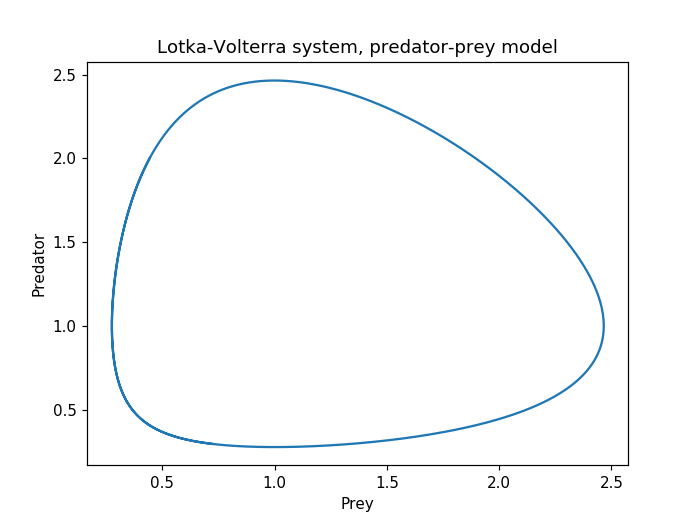

In [4]:
%matplotlib notebook
# plot the solutions curves (x,v)
plt.title('Lotka-Volterra system, predator-prey model')
plt.xlabel('Prey')
plt.ylabel('Predator')
plt.plot(x,v)
plt.savefig('VLorig.png')
#plt.plot(x)
#plt.plot(v)

# Now we check how good is the reprodction by solving the 

# Tadaaah, wen wundert's, dass rauskommt, was man reinsteckt, hehehehe

In [5]:
def DVecCMat(ydot,XV,n):
    x,v=XV
    laver=len(x)
    l=(n+1)*(n+2)//2
    cijn=np.append(np.array(np.where(np.less_equal(*np.mgrid[-n-1:0,-1:-n-2:-1]))),np.arange(l)).reshape(3,l).T
    dim=len(cijn)
    c=np.zeros((dim,dim),dtype=float)
    d=np.zeros(dim,dtype=float)
    for i,j,r in cijn:
        d[r]=np.sum(ydot*x**i*v**j)
        for k,l,s in cijn:
            c[r,s]=np.sum(x**i*v**j*x**k*v**l)
    return d,c

In [6]:
# Calculate the coefficients for the r.h.s. of vdot
d,c=DVecCMat(xdot,XV,3)
#print(np.einsum('ij,j->i',np.linalg.inv(c),d)[[1,4,7]],'\n',axdot[[1,4,7]])
axdot=np.einsum('ij,j->i',np.linalg.inv(c),d)
# Calculate the coefficients for the r.h.s. of vdot
d,c=DVecCMat(vdot,XV,3)
#print(np.einsum('ij,j->i',np.linalg.inv(c),d)[[1,4,7]],'\n',avdot[[1,4,7]])
avdot=np.einsum('ij,j->i',np.linalg.inv(c),d)

In [7]:
def ffit(t,r,*argv):
    x,v=r
    #return np.asarray(argv[0])
    #axdot,avdot=np.asarray(argv[0])
    axdot,avdot=argv
    l=len(axdot)
    n=int((-3+np.sqrt(1+8*l))//2)
    c=np.zeros((n+1,n+1),dtype=float)
    cbool=np.less_equal(*np.mgrid[-n-1:0,-1:-n-2:-1])
    c[cbool]=axdot
    dxdt=poly.polyval2d(x,v,c)
    l=len(avdot)
    n=int((-3+np.sqrt(1+8*l))//2)
    c=np.zeros((n+1,n+1),dtype=float)
    cbool=np.less_equal(*np.mgrid[-n-1:0,-1:-n-2:-1])
    c[cbool]=avdot
    dvdt=poly.polyval2d(x,v,c)
    return dxdt,dvdt

In [8]:
solfit=solve_ivp(ffit, [t0, t1], r0,method='RK45',t_eval=teval,rtol=rtol,atol=atol,args=(axdot,avdot))
xfit=solfit.y[0]
vfit=solfit.y[1]

<IPython.core.display.Javascript object>


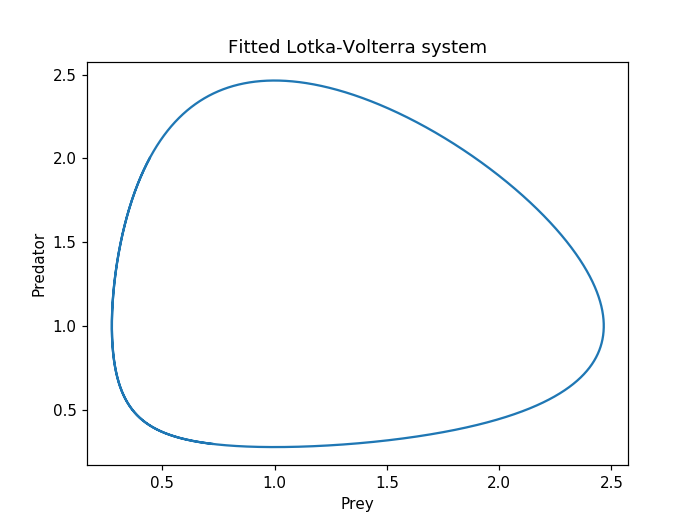

In [9]:
%matplotlib notebook
# plot the solutions curves (x,v)
plt.title('Fitted Lotka-Volterra system')
plt.xlabel('Prey')
plt.ylabel('Predator')
plt.plot(xfit,vfit)
plt.savefig('VLFitted.png')
#plt.plot(v)

In [10]:
np.max(np.abs(vfit-v))

1.6693056132943696e-06

<IPython.core.display.Javascript object>


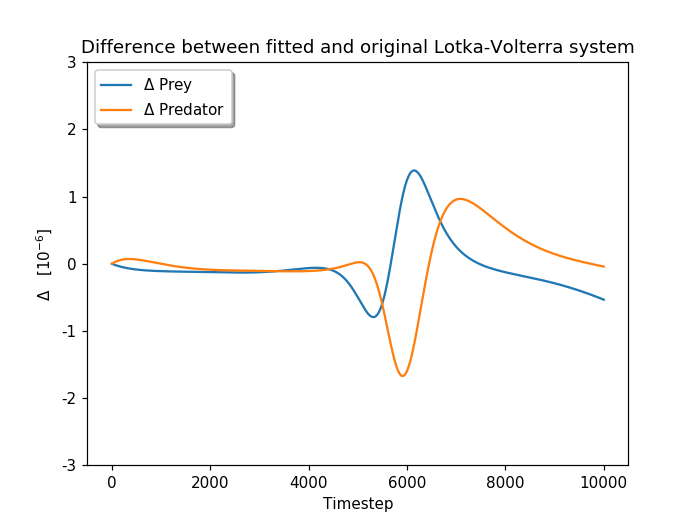

In [11]:
%matplotlib notebook
# plot the solutions curves (x,v)
fix,ax=plt.subplots()
plt.title('Difference between fitted and original Lotka-Volterra system')
plt.ylabel(r'$10^{-6}$')
ax.plot(xfit-x,label='$\Delta$ Prey')
ax.plot(vfit-v,label='$\Delta$ Predator')
ax.legend(loc='upper left', shadow=True)#, fontsize='x-large')
plt.xlabel('Timestep')
plt.ylabel('$\Delta\quad [10^{-6}]$ ')
plt.yticks([-3.e-6,-2.e-6,-1.e-6,0.,1.e-6,2.e-6,3.e-6],[-3,-2,-1,0,1,2,3])
plt.savefig('VLDifference.png')
#plt.plot(v)